## 📘 02_preprocessing.ipynb – Imputación y tratamiento de valores atípicos

Este notebook contiene el preprocesamiento del dataset de diabetes, incluyendo:

- Reemplazo de valores no válidos.
- Imputación de valores faltantes.
- Detección visual de outliers.
- Exportación del dataset limpio para uso posterior.

### 1. Carga del dataset y configuración de librerías

Importamos las librerías necesarias y visualizamos las primeras filas del conjunto de datos.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo gráfico
sns.set(style="whitegrid")
%matplotlib inline

# Cargar el dataset limpio desde la ruta relativa
df = pd.read_csv("../data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2. Detección de valores inválidos (ceros)

Algunas variables biométricas no pueden tener valores igual a cero. A continuación identificamos cuántos ceros hay en las columnas críticas.


In [15]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ver cuántos ceros hay en cada una
df[columns_with_zeros].eq(0).sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

### 3. Reemplazo de ceros por valores faltantes

Reemplazamos los ceros por `NaN` para poder imputarlos posteriormente.


In [16]:
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### 4. Imputación de valores faltantes usando mediana

La mediana es preferida porque es robusta ante valores extremos (outliers).


In [17]:
df[columns_with_zeros] = df[columns_with_zeros].fillna(df[columns_with_zeros].median())
df.isnull().sum()

# Verificar si los valores han sido reemplazados correctamente
df[columns_with_zeros].eq(0).sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

### 5. Visualización de posibles valores atípicos (outliers)

Usamos boxplots para detectar visualmente si existen valores atípicos en las variables.


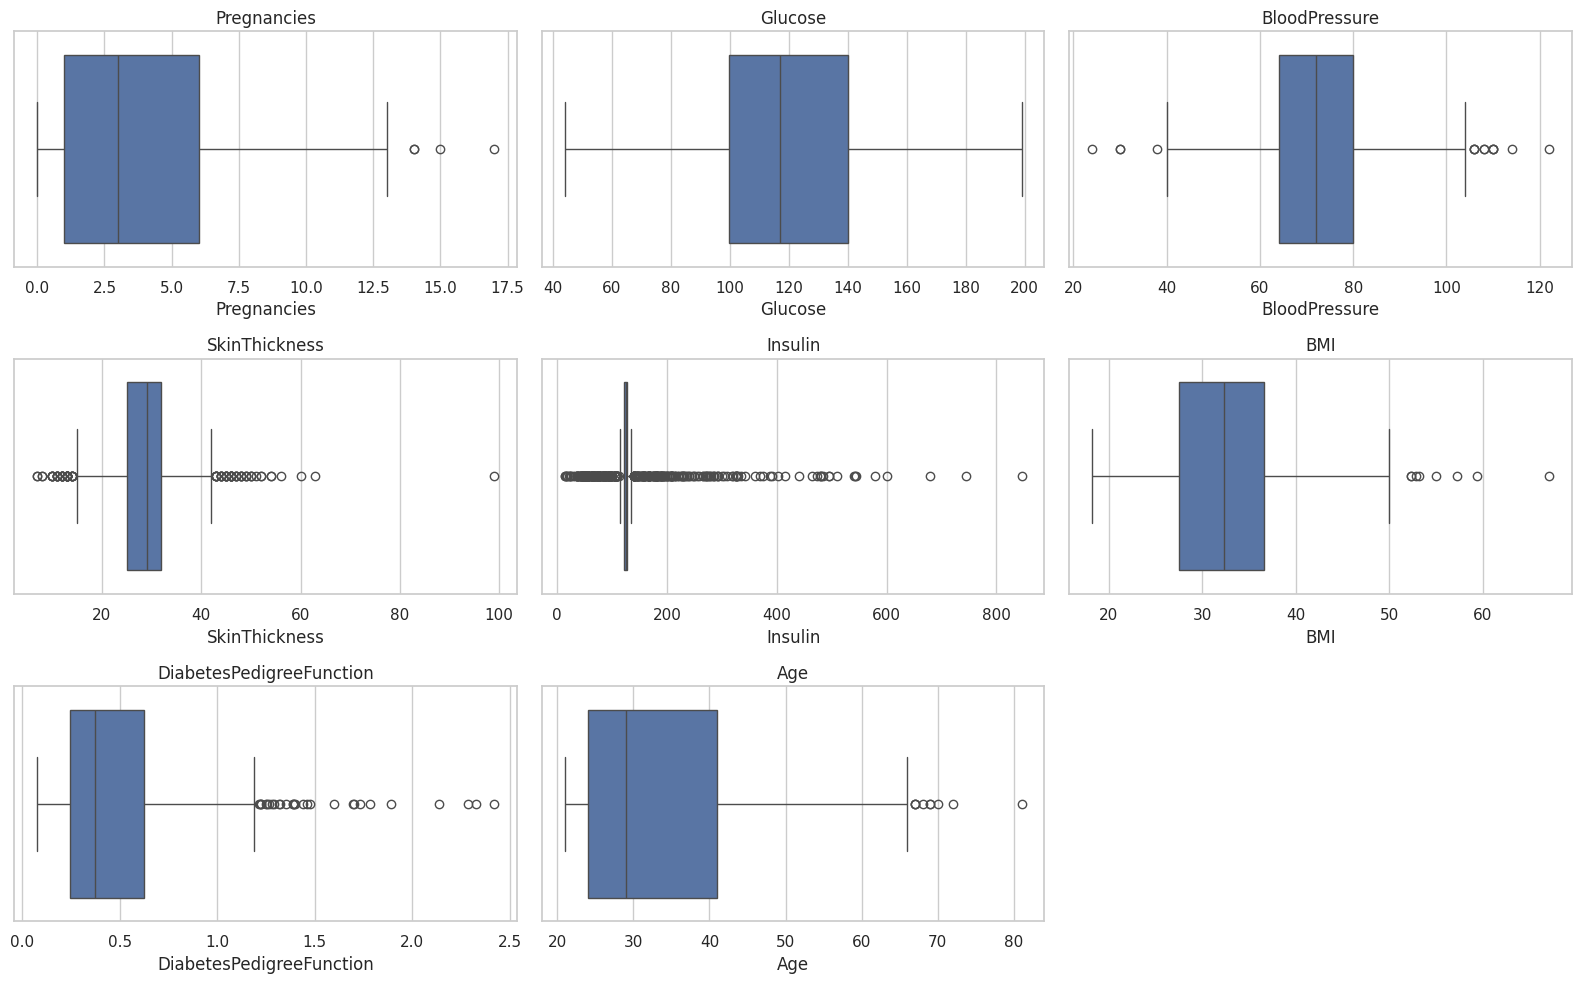

In [18]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


🎯 Tratamiento de outliers: Capping por percentiles

Durante el análisis exploratorio, se detectaron valores extremos (outliers) en algunas variables numéricas, como `Insulin` y `SkinThickness`, con valores muy superiores al rango típico de la población.

Se decidió aplicar **capping** por percentiles (también llamado recorte), que consiste en limitar los valores extremos a los percentiles 1% y 99%. Esta técnica presenta las siguientes ventajas en este caso:

- 🔹 **Preserva el tamaño del dataset**, lo cual es importante dado que solo se cuenta con 768 registros.
- 🔹 **Evita que los valores extremos sesguen el entrenamiento** de modelos sensibles como regresión logística o SVM.
- 🔹 **Es menos agresiva que eliminar datos**, lo que permite conservar patrones valiosos.

Las variables seleccionadas para capping fueron aquellas con mayor presencia de outliers detectados previamente.


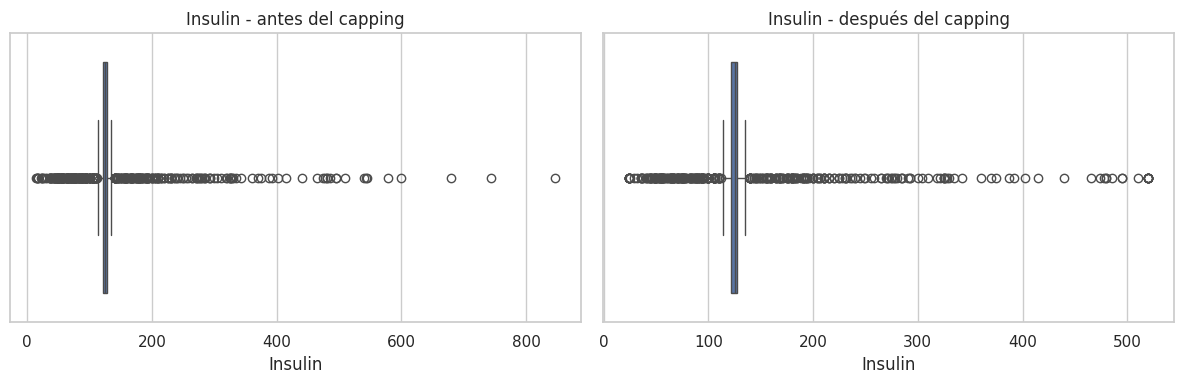

In [19]:
# Aplicación de capping (recorte) en variables con outliers

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['Insulin'], ax=axes[0])
axes[0].set_title("Insulin - antes del capping")

cols_to_cap = ['Insulin', 'SkinThickness', 'BloodPressure', 'BMI']

for col in cols_to_cap:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=q_low, upper=q_high)

sns.boxplot(x=df['Insulin'], ax=axes[1])
axes[1].set_title("Insulin - después del capping")
plt.tight_layout()
plt.show()

🧪 Efecto del capping en la variable `Insulin`

Como se observa en el boxplot, la aplicación de capping entre los percentiles 1% y 99% redujo notablemente la influencia de los valores atípicos extremos sin eliminar registros. Esto mejora la robustez de los modelos al tiempo que se conserva la información general del dataset.

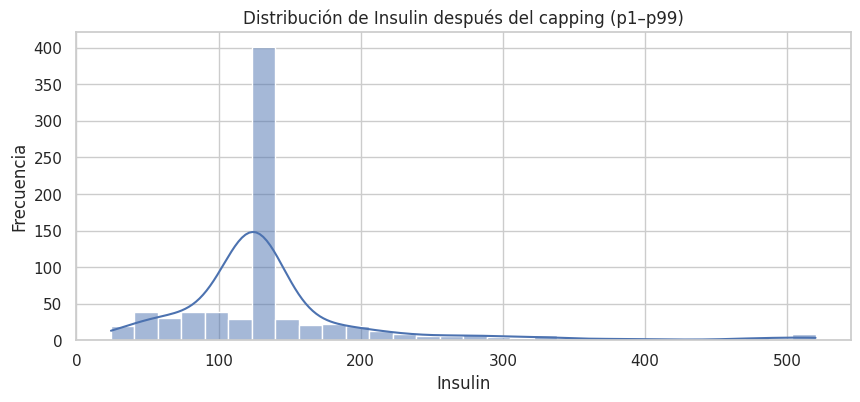

In [20]:
plt.figure(figsize=(10,4))
sns.histplot(df['Insulin'], bins=30, kde=True)
plt.title("Distribución de Insulin después del capping (p1–p99)")
plt.xlabel("Insulin")
plt.ylabel("Frecuencia")
plt.show()

In [26]:
skew_value = df['Insulin'].skew()
print(f"Asimetría (skewness) de Insulin: {skew_value:.2f}")

Asimetría (skewness) de Insulin: 2.67


#### Transformación logarítmica de la variable Insulin

La variable `Insulin` mostró una asimetría significativa positiva (> 1) incluso después del tratamiento de outliers.  
Se aplicó una transformación logarítmica (`log1p`) para reducir el sesgo y estabilizar la varianza, lo cual puede mejorar el rendimiento de modelos lineales y árboles poco profundos.  
Se reemplazó la columna original con su versión transformada.


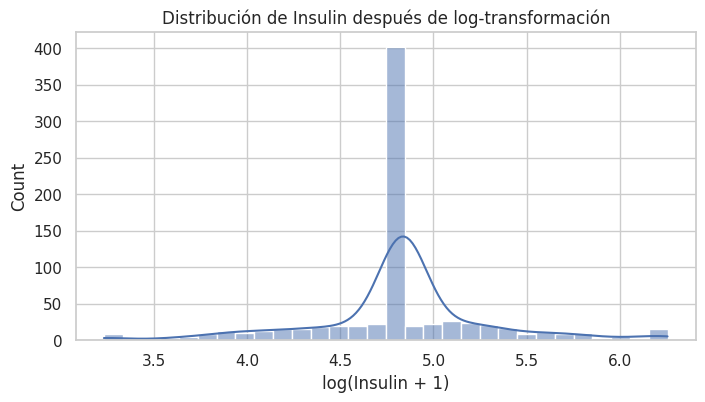

In [25]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Insulin_log'], bins=30, kde=True)
plt.title('Distribución de Insulin después de log-transformación')
plt.xlabel('log(Insulin + 1)')
plt.show()


In [28]:
df['Insulin_log'] = np.log1p(df['Insulin'])
df.drop(columns='Insulin', inplace=True)
df.rename(columns={'Insulin_log': 'Insulin'}, inplace=True)


### 6. Distribución de variables imputadas

Visualizamos cómo quedaron distribuidas las variables después de la imputación.


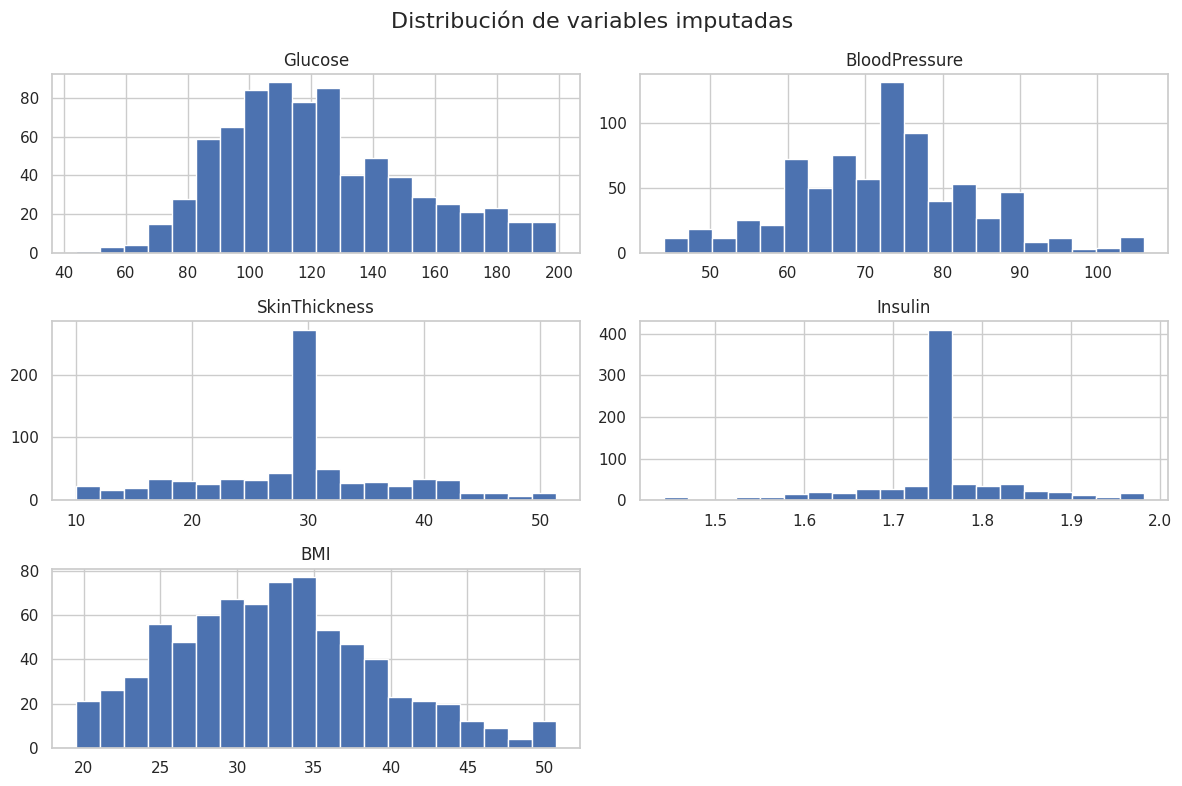

In [29]:
df[columns_with_zeros].hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribución de variables imputadas", fontsize=16)
plt.tight_layout()
plt.show()


### 7. Guardar el dataset limpio

Exportamos el nuevo dataset para usarlo en el siguiente paso de entrenamiento del modelo.


In [30]:
df.to_csv("../data/diabetes_clean.csv", index=False)
print("✅ Dataset limpio guardado como 'diabetes_clean.csv'")
# Verificar si el archivo se ha guardado correctamente
saved_df = pd.read_csv("../data/diabetes_clean.csv")
saved_df.head()

✅ Dataset limpio guardado como 'diabetes_clean.csv'


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin
0,6,148.0,72.0,35.0,33.6,0.627,50,1,1.764094
1,1,85.0,66.0,29.0,26.6,0.351,31,0,1.764094
2,8,183.0,64.0,29.0,23.3,0.672,32,1,1.764094
3,1,89.0,66.0,23.0,28.1,0.167,21,0,1.714496
4,0,137.0,44.0,35.0,43.1,2.288,33,1,1.813178


### ✅ Conclusiones

- Se identificaron y reemplazaron valores inválidos en las variables clave (valores de cero).
- Se imputaron los valores faltantes utilizando la mediana.
- Se visualizaron valores atípicos sin eliminarlos (serán considerados más adelante).
- El nuevo dataset se guardó como `diabetes_clean.csv`.
